In [110]:
# All the imports you will need in the whole lab
from skimage import io
from skimage.filters import median, gaussian
import skimage.exposure as exposure
from scipy.signal import convolve2d
from skimage.morphology import *
from skimage.color import rgb2gray, rgb2hsv, rgb2yuv, rgb2ycbcr
from skimage.measure import find_contours
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import hog as hog_sk
import os
import numpy as np
from commonfunctions import *
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage.util import img_as_float
from scipy.spatial.distance import squareform, pdist, cdist
from skimage.draw import polygon
from sklearn import svm
from joblib import dump, load
import cv2

In [111]:
def skin_mask_rgb(img):
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    rgb_max = np.maximum(np.maximum(red_channel, green_channel), blue_channel)
    rgb_min = np.minimum(np.minimum(red_channel, green_channel), blue_channel)
    rgb_rule_1 = np.logical_and.reduce([
        red_channel > 95, green_channel > 60, blue_channel > 60,
        rgb_max - rgb_min > 15, abs(red_channel - green_channel) < 80, abs(red_channel - blue_channel) < 80,red_channel > green_channel, red_channel > blue_channel
    ])
    
    
    return rgb_rule_1

In [112]:
def adaptive_thresholding(img):
    hist = exposure.histogram(img, nbins=256)
    total_num_of_pixels = img.shape[0]*img.shape[1]
    initial_threshold = round(sum(hist[1]*hist[0])/total_num_of_pixels)
    grey_level_count = hist[1][-1]
    while True:
        list_of_lower_values = hist[1][hist[1] < initial_threshold]
        frequency_of_lower_values = hist[0][hist[1] < initial_threshold]
        lower_threshold = round(sum(list_of_lower_values*frequency_of_lower_values)/sum(frequency_of_lower_values))

        list_of_higher_values = hist[1][hist[1] >= initial_threshold]
        frequency_of_higher_values = hist[0][hist[1] >= initial_threshold]
        upper_threshold = round(sum(list_of_higher_values*frequency_of_higher_values)/sum(frequency_of_higher_values))
        new_threshold = round((lower_threshold + upper_threshold)/2)
        
        if new_threshold == initial_threshold:
            break
        else:
            initial_threshold = new_threshold
    return new_threshold

In [113]:
def get_hand_contours(hand_img):
    #get the center of the hand
    hand_img = hand_img.astype(np.uint8)
    contours = find_contours(hand_img, 0.8, fully_connected='high')
    contouring_threshold = 0
    # get contoring threshold by finding the min length of the longest 3 contours
    contouring_threshold = sorted([c.shape[0] for c in contours])[-2]
    contours_saved = []
    for c in contours:
    #draw the contour if it is not too small
        if c.shape[0] > contouring_threshold: 
            #plt.plot(c[:, 1], c[:, 0], linewidth=2)
            contours_saved.append(c)
    return contours_saved


In [114]:
def normalize_img(img):
    #resize photo so that only the hand is visible
    # get the most left pixel that is not black
    most_left = np.where(img.sum(axis=0) != 0)[0][0]
    most_top = np.where(img.sum(axis=1) != 0)[0][0]
    most_right = np.where(img.sum(axis=0) != 0)[0][-1]
    most_bottom = np.where(img.sum(axis=1) != 0)[0][-1]
    resized_img = img[most_top:most_bottom, most_left:most_right]
    return resized_img

In [115]:
def trace_hand_contours(img, longest_contours):
    outline = np.zeros(img.shape)
    for c in longest_contours:
        #convert c to int
        c = c.astype(int)
        outline[c[:,0], c[:,1]] = 1
    return outline

In [116]:
def fill_hand(img, contours):
    #fill the hand with white
    result = img.astype(np.uint8)
    for c in contours:
        rr, cc = polygon(c[:,0], c[:,1])
        result[rr, cc] = 1
    return result

In [117]:
def is_bright(img):
    img = rgb2hsv(img)
    v = img[:,:,2]
    v = v*255
    v = gaussian(v, sigma=1)
    thresh = adaptive_thresholding(v)
    print(thresh)
    if thresh > 110:
        print("bright")
        return True
    else:
        print("dark")
        return False

In [118]:
def feature_extraction(img):
    #feature is a 25x25 matrix each cell is the output birghtness of a 5x5 pixel in the image
    b = np.zeros((42,42))
    #we get the brightness of each cell by taking the average of the brightness of the pixels in the cell
    for i in range(0,42):
        for j in range(0,42):
            b[i,j] = np.sum(img[i*3:(i+1)*3,j*3:(j+1)*3])
    # print(b)
    #show_images([b], ['feature'])
    return b

In [119]:
def compare_feature(b1, b2):
    #compare the feature of two images
    #if the two feature are black we consider them the same
    #if the two feature are white have the same brightness we consider them the same
    #if the two feature are white but have different brightness whithin a certain threshold we consider them the same
    print(np.max(b1), np.min(b1))
    print(np.max(b2), np.min(b2))
    matches = 0
    for i in range(0,42):
        for j in range(0,42):
            if (b1[i,j] == 0 and b2[i,j] == 0):
                matches = matches + 1
            # elif (b1[i,j] == b2[i,j]):
            #     matches = matches + 1
            elif (b1[i,j] > 0.2 and b2[i,j] > 0.2):
                matches = matches + 1
    print (matches)
    print (matches/(42*42))

In [120]:
def resize_img(img1):
    #resize photo to 200x200
    img_new = resize(img1, (256, 256), anti_aliasing=False)
    return img_new

In [121]:
def pre_processing (img):
    if(is_bright(img) == False):
        img = rgb2gray(img)
        img = img*255
        filterd = gaussian(img, sigma=5)
        best_threshold = adaptive_thresholding(filterd)
        thresholded = filterd > best_threshold
        result = thresholded
        result = canny(result, sigma=3)
        result = normalize_img(result)
        result = resize_img(result)
    else:
        mask = skin_mask_rgb(img)
        longest_contours = get_hand_contours(mask)
        result = trace_hand_contours(mask, longest_contours)
        #result = fill_hand(result, longest_contours)
        result = normalize_img(result)
        result = resize_img(result)   
        se = np.ones((1,1))
        result = binary_dilation(result, se)
    return result 

In [122]:
def compute_gradient(image):
    gx = np.zeros((image.shape[0], image.shape[1]))
    gy = np.zeros((image.shape[0], image.shape[1]))
    image = image.astype(np.float32)
    gx[:, 1:-1] = (image[:, 2:] - image[:, :-2]) / 2
    gy[1:-1, :] = (image[2:, :] - image[:-2, :]) / 2
    
    gx[:, 0] = image[:, 1] - image[:, 0]
    gy[0, :] = image[1, :] - image[0, :]
    
    gx[:, -1] = image[:, -1] - image[:, -2]
    gy[-1, :] = image[-1, :] - image[-2, :]
    return gx, gy

In [123]:
def hog_cell(orientations, magnitudes, n):
    bin_size = int(180 / n)
    hog = np.zeros(n)
    for i in range(orientations.shape[0]):
        for j in range(orientations.shape[1]):
            angle = orientations[i, j]
            magnitude = magnitudes[i, j]
            bin = int(angle / bin_size)
            if bin == n:
                bin = n - 1
            hog[bin] += magnitude
            
    return hog/(magnitudes.shape[0]*magnitudes.shape[1])

In [124]:
def normalize_vector(v):
    epsion = 1e-5
    return v / np.sqrt(np.sum(v ** 2) + epsion ** 2) 

In [125]:
def get_hog_featrue(img):
    gx, gy = compute_gradient(img)
    x, y = gx.shape
    cx , cy = 8, 8
    bx , by = 1, 1
    
    magnitude = np.sqrt(gx**2 + gy**2)
    angels = np.rad2deg(np.arctan2(gy, gx)) % 180
    
    n_cells_x = int(x / cx)
    n_cells_y = int(y / cy)
    n_blocks_x = n_cells_x - bx + 1
    n_blocks_y = n_cells_y - by + 1
    
    cells = np.zeros((n_cells_x, n_cells_y, 9))
    prev_x = 0
    for i in range(n_cells_x):
        prev_y = 0
        for j in range(n_cells_y):
            cells[i, j] = hog_cell(angels[prev_x:prev_x+cx, prev_y:prev_y+cy], magnitude[prev_x:prev_x+cx, prev_y:prev_y+cy], 9)
            prev_y += cy
        prev_x += cx
    
    cells_norm = np.zeros((n_blocks_x, n_blocks_y, 9))
    #normalize the cells
    
    for i in range(n_blocks_x):
        for j in range(n_blocks_y):
            cells_norm[i, j] = normalize_vector(cells[i:i+bx, j:j+by].ravel())
            
    return cells_norm.ravel()

In [126]:
def get_paper_hand_imgs():
    imgs = []
    labels = []
    #open folder with paper hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/five/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("paper")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("paper")
    return imgs, labels

def get_rad_hand_imgs():
    imgs = []
    labels = []
    #open folder with rock hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/rad/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("rad")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("rad")
    return imgs, labels

def get_peace_hand_imgs():
    imgs = []
    labels = []
    #open folder with scissors hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/peace/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("peace")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("peace")
    return imgs, labels

def get_fist_hand_imgs():
    imgs = []
    labels = []
    #open folder with thumbs up hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/fist/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("fist")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("fist")
    return imgs, labels

def get_thumbsup_hand_imgs():
    imgs = []
    labels = []
    #open folder with thumbs up hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/thumbs/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("thumbs")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("thumbs")
    return imgs, labels

def get_perfecto_imgs():
    imgs = []
    labels = []
    weights = []
    #open folder with thumbs up hands
    #get all images in folder and append to imgs
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/okay/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("perfecto")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("perfecto")
    return imgs, labels

def get_straight_imgs():
    imgs = []
    labels = []
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/straight/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        img = canny(img, sigma=1)
        img_flipped = np.fliplr(img)
        img_flipped = normalize_img(img_flipped)
        resized_flipped = resize_img(img_flipped)
        imgs.append(resized_flipped)
        labels.append("straight")
        img = normalize_img(img)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("straight")
    return imgs, labels

def get_none_imgs():
    imgs = []
    labels = []
    path = 'C:/Users/Fastora/Downloads/HandGestureDetection/data/data/data/train/none/'
    for filename in os.listdir(path):
        img = io.imread(path+filename)
        resized = resize_img(img)
        imgs.append(resized)
        labels.append("none")
    return imgs, labels

In [127]:
def extract_features(imgs_labels, feature_vector=True):
    features = []
    labels = []
    for img_label in imgs_labels:
        #get hog features of image and append to features and label to labels
        fd = get_hog_featrue(img_label[0])
        labels.append(img_label[1])
        features.append(fd)
    return features, labels

In [128]:
paper_imgs , paper_labels = get_paper_hand_imgs()
peace_imgs , peace_labels = get_peace_hand_imgs()
fist_imgs , fist_labels = get_fist_hand_imgs()
rad_imgs , rad_labels = get_rad_hand_imgs()
thumbs_imgs , thumbs_labels = get_thumbsup_hand_imgs()
perfecto_imgs , perfecto_labels = get_perfecto_imgs()
straight_imgs , straight_labels = get_straight_imgs()
none_imgs , none_labels = get_none_imgs()


In [129]:
imgs_labels = []
for i in range(len(paper_imgs)):
    imgs_labels.append((paper_imgs[i], paper_labels[i]))
for i in range(len(fist_imgs)):
    imgs_labels.append((fist_imgs[i], fist_labels[i]))
for i in range(len(peace_imgs)):
    imgs_labels.append((peace_imgs[i], peace_labels[i]))
for i in range(len(rad_imgs)):
    imgs_labels.append((rad_imgs[i], rad_labels[i]))
for i in range(len(thumbs_imgs)):
    imgs_labels.append((thumbs_imgs[i], thumbs_labels[i]))
for i in range(len(perfecto_imgs)):
    imgs_labels.append((perfecto_imgs[i], perfecto_labels[i]))
for i in range(len(straight_imgs)):
    imgs_labels.append((straight_imgs[i], straight_labels[i]))
for i in range(len(none_imgs)):
    imgs_labels.append((none_imgs[i], none_labels[i]))

In [130]:
features , labels = extract_features(imgs_labels)

In [131]:
clf = svm.SVC()
clf.fit(features, labels)

SVC()

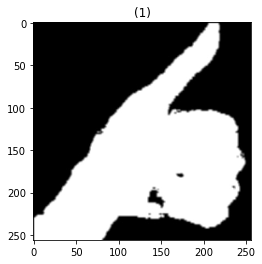

['perfecto']
['perfecto']


In [132]:
img = io.imread('900.jpg')
img = normalize_img(img)
img = resize_img(img)
show_images([img])
# proc = pre_processing(img)
# show_images([proc, img])
hg = get_hog_featrue(img)
print(clf.predict([hg]))

img2 = io.imread('91.png')
img2 = normalize_img(img2)
img2 = resize_img(img2)
hg2 = get_hog_featrue(img2)
print(clf.predict([hg2]))

In [133]:
# define a video capture object
vid = cv2.VideoCapture(0)
c=0
while(True):
    c+=1
    
    # Capture the video frame
    #open video in full screen
    vid.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    ret, frame = vid.read()
    roi=frame[100:500, 100:500]
    cv2.rectangle(frame,(90,90),(500,500),(0,255,0),0)    
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    # Display the resulting frame
    cv2.imshow('frame', frame)
    #take image from the rectangle 
    cv2.imshow('roi', roi)
    #take a photo every 2 seconds and save it
    # print(c)
    if c%20==0:
        #save the image
        #cv2.imwrite("hand"+str(i)+".jpg", roi)
        result=pre_processing(roi)
        #show_images([result], ['hand'])
        hg = get_hog_featrue(result)
        print(clf.predict([hg]))
        #convert int to string
        #i=str(i)
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

54
dark
['straight']
50
dark
['straight']
48
dark
['thumbs']
83
dark
['perfecto']
46
dark
['perfecto']
88
dark
['perfecto']
90
dark
['perfecto']
66
dark
['straight']
80
dark
['peace']
84
dark
['peace']
80
dark
['thumbs']
75
dark
['peace']
74
dark
['peace']
76
dark
['peace']
80
dark
['peace']
82
dark
['perfecto']
88
dark
['thumbs']
88
dark
['perfecto']
43
dark
['straight']
88
dark
['perfecto']
88
dark
['perfecto']
89
dark
['perfecto']
71
dark
['straight']
76
dark
['perfecto']
68
dark
['rad']
83
dark
['perfecto']
78
dark
['perfecto']
84
dark
['straight']
76
dark
['straight']
69
dark
['peace']
72
dark
['thumbs']
74
dark
['straight']
78
dark
['peace']
78
dark
['peace']
76
dark
['peace']
68
dark
['thumbs']
68
dark
['peace']
68
dark
['thumbs']
72
dark
['straight']
74
dark
['thumbs']
72
dark
['thumbs']
88
dark
['straight']
86
dark
['thumbs']
94
dark
['rad']
80
dark
['thumbs']
74
dark
['peace']
74
dark
['peace']
82
dark
['peace']
85
dark
['peace']
82
dark
['peace']
80
dark
['rad']
82
dark
['pe